## Homework 3: Machine learning

In this assignment, we'll practice the classification skills from machine learning. We'll use the precinct-level voting data to predict support for Prop 21 (rent control) on the 2020 ballot. For example, we might expect the share of renters to be an important predictor.

We'll also review joins as we prepare the data.

Start by loading the 2020 elections results from LA County into a `pandas` dataframe, `voteDf`. (This is exactly the same data as we will use next week in the clustering lectures; I put another copy of the data file in the assignment GitHub folder to make things easier.)

### Policy on ChatGPT / AI

This is the same as in HWs 1 and 2. Please review those guidelines.

Please help me grade by observing the following:
 
* Do not rename this notebook (that messes up the autograder)
* Do not include large sections of output (that makes it hard to find your code). For example, use `df.head()` to show the first few rows, rather than printing an entire dataframe. The same goes for printing long strings.

In [1]:
import os
os.getcwd()

'/Users/Tomo/Desktop/urbandatascience/hw3-tomo-ujikawa/hw3'

In [2]:
import pandas as pd

voteDf = pd.read_csv('c037_g20_sov_data_by_g20_srprec.csv')

print(len(voteDf))
print(voteDf.head())

4313
   county    srprec  addist  cddist  sddist  bedist  TOTREG  DEMREG  REPREG  \
0      19  0050005A      36      25      21       1    1974       0       0   
1      19  0050014A      36      25      21       1     697       0       0   
2      19  0050022A      36      27      25       1      61       0       0   
3      19  0050024A      41      27      25       1       0       0       0   
4      19  0050025A      36      25      25       1       5       0       0   

   AIPREG  ...  PR_23_Y  PR_24_N  PR_24_Y  PR_25_N  PR_25_Y  SENAIP01  \
0       0  ...      430      945      771     1304      398         0   
1       0  ...      100      314      223      427      116         0   
2       0  ...       10       27       22       35       15         0   
3       0  ...        0        0        0        0        0         0   
4       0  ...        1        2        3        1        3         0   

   SENDEM01  SENDEM02  SENLIB01  SENREP01  
0       524         0         0      

In [3]:
# Autograding tests - do not edit
assert len(voteDf) == 4313
assert isinstance(voteDf, pd.DataFrame)

To do some prediction, we'll want to add variables from (say) the census or other sources.
For that, we need the lookup file that matches precincts to census blocks and tracts. [You can find it here](https://statewidedatabase.org/d10/g20_geo_conv.html), or just use the file `c037_g20_sr_blk_map.csv` in your GitHub repository. (Note that there are several types of precincts; the ones that we are using here are called `srprec`.) 

Each precinct intersects with many census blocks. The `pctsrprec` column tells you how much of the precinct lies within that block. For example, in the first few rows of `c037_g20_sr_blk_map.csv`, you'll see 49 different rows for precinct `0050003A`, each matching to a different census block, with the `pctsrprec` column adding up to 100.

Our aim is to create a new dataframe with the vote counts (for all of the propositions and other races) aggregated to census tract. This is a multi-stage process, so let's do this step by step.

In this step, you should:
- load in the lookup data into a new dataframe, `lookupDf`
- join the voting dataframe to the lookup dataframe using `srprec`, to create a new dataframe called `joinDf`. This is a 1:many join, since there are many census blocks per precinct. Do an inner join, as the Null values are not going to be useful to us. (In other words, throw away any lookups that don't match a precinct.)
- make sure that `srprec` is the index

In [4]:
lookupDf = pd.read_csv('c037_g20_sr_blk_map.csv') 
voteDf.set_index('srprec', inplace=True)
lookupDf.set_index('srprec', inplace=True)
joinDf = voteDf.join(lookupDf, how = 'inner')

In [5]:
print(len(lookupDf))
print(len(joinDf))
print(joinDf.county.count())
print(joinDf.TOTREG.sum())
assert joinDf.index.name=='srprec'
assert len(lookupDf)==77704
assert len(joinDf)==77703
assert joinDf.county.count()==77703
assert joinDf.TOTREG.sum()==168427815

77704
77703
77703
168427815


Now let's calculate vote shares on Prop 21 and in the presidential race for each census tract. 

This is slightly tricky, because your data frame `joinDf` will have multiple rows per tract (because the precinct geography does not match the census geography). For example, the following code shows you which precincts intersect with tract 119342. 

13.65% of the first precinct listed, `9004204A`, is in tract 119342.

In [6]:
joinDf[joinDf.tract==119342][['tract','pctsrprec']].sort_index(ascending=False)

,tract,pctsrprec
srprec,,
9004204A,119342,13.653137
9000576A,119342,22.065955
9000576A,119342,25.412221
9000576A,119342,0.533463


So to aggregate to tracts, you should:
- for each relevant column, multiply the number of votes by `pctsrprec`, and divide by 100 (because `pctsrprec` is a percentage, not a fraction)
- group by census tract and sum those relevant columns, to create a new dataframe called `tractVotes`. It should have columns `PR_21_N`, `PR_21_Y`, `PRSDEM01`, `PRSREP01`, etc.

This will give us our estimate of votes at the tract level.

*Hint*: You can pass multiple columns to `groupby`. E.g. `df.groupby('groupcol')[['col1','col2','col3']].sum()`

In [7]:
joinDf.columns

Index(['county', 'addist', 'cddist', 'sddist', 'bedist', 'TOTREG', 'DEMREG',
       'REPREG', 'AIPREG', 'GRNREG', 'LIBREG', 'NLPREG', 'REFREG', 'DCLREG',
       'MSCREG', 'TOTVOTE', 'DEMVOTE', 'REPVOTE', 'AIPVOTE', 'GRNVOTE',
       'LIBVOTE', 'NLPVOTE', 'REFVOTE', 'DCLVOTE', 'MSCVOTE', 'PRCVOTE',
       'ABSVOTE', 'ASSDEM01', 'ASSDEM02', 'ASSGRN01', 'ASSIND01', 'ASSLIB01',
       'ASSREP01', 'ASSREP02', 'CNGDEM01', 'CNGDEM02', 'CNGREP01', 'PRSAIP01',
       'PRSDEM01', 'PRSGRN01', 'PRSLIB01', 'PRSPAF01', 'PRSREP01', 'PR_14_N',
       'PR_14_Y', 'PR_15_N', 'PR_15_Y', 'PR_16_N', 'PR_16_Y', 'PR_17_N',
       'PR_17_Y', 'PR_18_N', 'PR_18_Y', 'PR_19_N', 'PR_19_Y', 'PR_20_N',
       'PR_20_Y', 'PR_21_N', 'PR_21_Y', 'PR_22_N', 'PR_22_Y', 'PR_23_N',
       'PR_23_Y', 'PR_24_N', 'PR_24_Y', 'PR_25_N', 'PR_25_Y', 'SENAIP01',
       'SENDEM01', 'SENDEM02', 'SENLIB01', 'SENREP01', 'tract', 'block',
       'blkreg', 'srtotreg', 'pctsrprec', 'blktotreg', 'pctblk'],
      dtype='object')

In [8]:
cols = ['PR_21_N','PR_21_Y','PRSDEM01', 'PRSREP01']
for col in cols:
    joinDf[col] = joinDf[col] * joinDf['pctsrprec'] / 100

In [9]:
tractVotes = joinDf.groupby('tract')[cols].sum()

In [10]:
print(len(tractVotes))
print(tractVotes.PR_21_Y.sum())

# Autograding tests - do not edit
assert len(tractVotes)==2338
assert tractVotes.PR_21_Y.sum().round() == 2021487

2338
2021486.9997128805


Now let's get a dataframe of some relevant census variables, using the Census Bureau API. Check back to the Week 1 example and the first homework.

Create a dataframe, `censusDf`, with ACS 2019 (5 year) tract-level data for LA County, and variables for Tenure (B25003_001E, B25003_002E, B25003_003E) and median household income (B19013_001E). Add a column with the percent of renters, called `pct_renter`.

Rename the median HH income column `median_hh_income`, which is more meaningful.

Why use ACS 2019 rather than a more recent vintage? Well, the census tract boundaries change after each decennial census (i.e., in 2020), and the precinct-to-tract files we used above map to the pre-2020 census boundaries.

As a reminder, here's the Census API [list of tables](https://api.census.gov/data/2019/acs/acs5/variables.html), and [here are examples that you can adapt](https://api.census.gov/data/2019/acs/acs5/examples.html). 

*Hint:* Make sure to restrict your data request by state AND county if you want to keep it to a manageable size! You shouldn't need to request an API key for a small number of queries..

*Hint:* Look at your data if you get the wrong answer to median income! For example, use `censusDf.describe()`, or `censusDf.sort_values(by='med_hh_income').head()`. You might need to replace some values with `np.nan`.

In [11]:
import requests
import json
import numpy as np

In [12]:
key = 'e024759e68ac64e5f031a35c74016bdf988adce6'
url = 'https://api.census.gov/data/2019/acs/acs5?get=NAME,B25003_001E,B25003_002E,B25003_003E,B19013_001E&for=tract:*&in=state:06%20county:037&key={}'.format(key)
r = requests.get(url)
censusdata = r.json()

In [13]:
censusDf = pd.DataFrame(censusdata[1:], columns=censusdata[0])

In [14]:
censusDf['pct_renter'] = censusDf['B25003_003E'].astype(int)/censusDf['B25003_001E'].astype(int)*100
censusDf.rename(columns = {'B19013_001E':'median_hh_income'}, inplace=True)
censusDf['median_hh_income'] = censusDf.median_hh_income.astype(int)

In [15]:
censusDf.loc[censusDf['median_hh_income'] < 0, 'median_hh_income'] = np.nan

In [16]:
print (len(censusDf))
print (censusDf.pct_renter.mean())
print(censusDf.median_hh_income.mean())

# Autograding tests - do not edit
assert len(censusDf) == 2346
assert censusDf.pct_renter.mean().round() == 53
assert censusDf.median_hh_income.mean().round()==73243

2346
53.273758713248945
73242.84415584416


Create a new dataframe, `joinedDf`, with both your voting and census data, through a left join to the voting data. 

*Hint*: It will be easiest to join on the `tract` column (which is your index in `tractVotes`). Since everything is in LA County, you don't need to worry about the `state` or `county` fields.

*Hint*: You'll need to convert the `tract` column in `censusDf` to an integer first.

In [17]:
joinedDf = 9999

In [18]:
tractVotes

,PR_21_N,PR_21_Y,PRSDEM01,PRSREP01
tract,,,,
101110,1024.227956,857.734445,1090.712262,895.321045
101122,1138.460030,747.218978,1057.143636,896.821118
101210,714.308221,849.445489,949.817716,723.604530
101220,761.014272,528.747773,747.489059,604.907175
101300,1218.104598,796.031104,1159.946654,948.800765
...,...,...,...,...
980025,1.191385,1.331692,2.144000,0.435692
980026,3.443450,2.245728,3.248169,2.688365
980028,13.480156,15.983655,23.790061,6.556109


In [19]:
censusDf['tract'] = censusDf['tract'].astype(int) 
censusDf.set_index('tract', inplace=True)

In [20]:
joinedDf = tractVotes.join(censusDf, how = 'left')

In [21]:
print(joinedDf.pct_renter.count())
print(joinedDf.pct_renter.mean())

# Autograding tests - do not edit
assert joinedDf.pct_renter.count() == 2318
assert joinedDf.pct_renter.mean().round() == 53

2318
53.28817335153003


Let's start with a simple random forests model with the following *x* variables:

* Median HH income
* Percent of HHs that are renters
* Presidential vote (2-party share of Democrat voters, i.e. the percent voting for Biden vs Trump, with other candidates ignored)

And the following *y* variable
* Whether Prop 21 won (received a majority) in that census tract. This should be `True` if the Yeses got more votes than the Nos.

(Yes, vote share in each tract would be better to predict rather than a binary variable - hold off on that for the challenge problem.)

Create the relevant columns, `pct_biden` and `PR_21_won`, in your `joinedDf` dataframe. 

Then split your dataframe into a training sample (75%) and a test sample (25%). *Hint*: Drop the `NaNs` first.

In [22]:
joinedDf['pct_biden'] = joinedDf['PRSDEM01']/(joinedDf['PRSDEM01']+joinedDf['PRSREP01'])*100
joinedDf['pct_21_won'] = joinedDf['PR_21_Y']/(joinedDf['PR_21_Y']+joinedDf['PR_21_N'])*100
joinedDf['PR_21_won'] = joinedDf['pct_21_won'] > 50

In [24]:
# your code here
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

xvars = ['median_hh_income', 'pct_renter', 'pct_biden']
yvar = 'PR_21_won'

df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

In [26]:
print(len(X_train))
print(len(X_test))
print(X_train.pct_biden.mean())
print(y_train.mean())

# Autograding tests - do not edit
assert len(X_train) == 1731
assert len(X_train.columns) == 3
assert len(X_test) == 578
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert X_train.pct_biden.mean().round() == 74
assert y_train.mean().round(1) == 0.6


1731
578
73.99448083312072
0.5979202772963604


Estimate a random forests model, and assign the predicted *y* values from your *test* sample to `y_pred`.

In [27]:
from sklearn.ensemble import RandomForestClassifier 

y_pred = rf.predict(X_test)

In [28]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.6298. Actual fraction True: 0.6142


In [29]:
print(len(y_pred))
print(y_pred.mean())

# Autograding tests - do not edit
assert len(y_pred)==len(y_test)
assert y_pred.mean().round(1) == 0.6

578
0.629757785467128


Let's look at some measures of fit. Plot the confusion matrix.

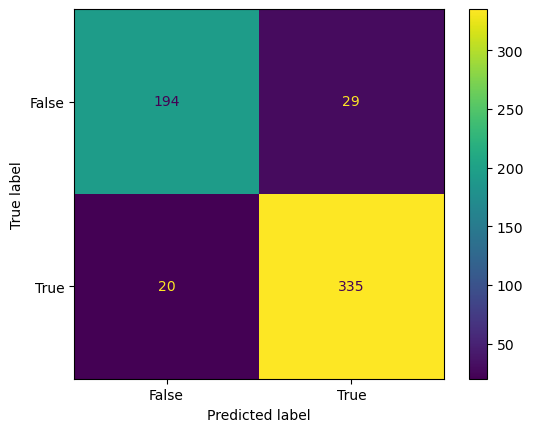

In [30]:
# your code here
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Finally, plot the importance of each of the 3 predictor variables, in the same way as we did in class.

Text(0, 0.5, 'Mean decrease in impurity')

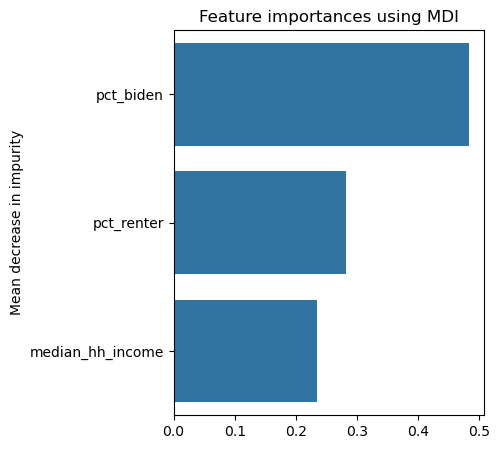

In [31]:
# your code here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Comment on your interpretation of the results and the confusion matrix. What do they tell you about:
- your predictive accuracy
- which variables are important
- how you might refine the model

YOUR ANSWER HERE

Predicted fraction of winning is 0.63, and the actual fraction is 0.61. So, I judge this prediction's accuracy level to be good.
The proportion of pro-Biden votes in the presidential election is the most important factor in predicting the proportion of tracts supporting Prop 21.
I might be able to improve the model by increasing the number of variables included in the model, such as race, education, geometry, though I don't know if there's spatial correlation, I assume there are more liberals in urban areas and higher renters while suburban areas tend to have more conservatives with home owners. These variables must all be correlated, but they might help make the model more precise. Increasing the number of trees from 50 to, say, 100 would also improve the accuracy.

# Challenge Problem
Remember, you need to do at least two of these challenge problems this quarter.

This challenge problem is open ended for you to take in a direction that you are most interested in. Here are some suggestions (do 1 or 2 of these):

* Extend the random forests model to predict vote share on Prop 21, rather than a binary yes/no, and using additional variables. See suggestions below. 
* Use a neural network instead. How much does this improve the predictions? Use charts to compare the predictions to the random forests model.
* Examine the geographic distribution of the predictions, through mapping the prediction errors. Where does your model perform best? Does this give you pointers as to how to improve your model?

In all cases, write some brief interpretation in a markdown cell.

*Predicting a continuous variable*

Classification problems are typically binary or categorical - which category do you predict a given observation to fall into. In some cases, however, we might want to predict a continuous variable, such as the percentage of "yes" votes on Prop 21. For this we can use `RandomForestRegressor`, which works very similarly to `RandomForestClassifier`. You can follow exactly the same steps: create the `rf` object, fit the model, and predict using the test sample.

How do you evaluate model performance? Since we have a continuous variable, we can't use the confusion matrix. But we can look at the absolute error (each predicted value minus the true value for each of our test precincts). I.e., `abs(y_pred-y_test)`. You can also do a scatter plot of the predicted values against the true values. The divergence from the 45 degree line is a good indication of how well the model fits.